# What does the public want?

## Identifying the main themes in UK Parliament e-petitions

The ability to petition Parliament gives the people **power to join together in support of causes and effect change**. In the UK, British citizens and UK residents are able to create petitions on the UK Parliament petitions website; at 10,000 signatures petitions will get a response from the government, at 100,000 signatures petitions will be considered for a debate in Parliament (though it's of course not always successful, take [Revoke Article 50 and remain in the EU](https://petition.parliament.uk/archived/petitions/241584) for example).

**But what, you ask, are the themes that keep appearing?** In an age of information overload, it can be hard to keep track. In this notebook I use natural language processing andtopic modelling to pull out the key themes in petitions submitted by members of the public to the UK Parliament e-petitions website.

Data is sourced from the [UK Parliament petitions website](https://petition.parliament.uk/), available under the Open Government Licence v3.0 ([OGL v3.0](https://www.nationalarchives.gov.uk/doc/open-government-licence/version/3/)). More info on the history of the UK Parliament petitions website can be found in the [wikipedia entry](https://en.wikipedia.org/wiki/UK_Parliament_petitions_website).

### Import libraries

In [31]:
import glob, os
import pandas as pd
import pickle

In [2]:
import urllib3
from bs4 import BeautifulSoup
import json
import time

http = urllib3.PoolManager()

In [41]:
import re
import spacy
from spacy.lang.en import English
import gensim
from gensim.models import TfidfModel
#import pyLDAvis.gensim

import multiprocessing as mp

ModuleNotFoundError: No module named 'pyLDAvis'

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

sns.set(font_scale=1.2)

#### Functions to read and write to pickle

In [20]:
def write_pkl(fname, obj):
    with open(fname,'wb') as pklf:
        pickle.dump((obj), pklf)
        print('Saved to', fname)
        
def read_pkl(fname):
    with open(fname,'rb') as pklf:
        obj = pickle.load(pklf)
    return obj

### Get the data

First, I download lists (CSV format) of current and archived petitions from the [UK Parliament petitions website](https://petition.parliament.uk/). At time of accessing the data, the archive covers 2010-2019, and current through to mid- 2021.

#### Read the lists of petitions

Stored locally in `data/`.

In [112]:
df = pd.DataFrame()

for f in glob.glob('data/*.csv'):
    df = df.append(pd.read_csv(f, header=0), ignore_index=True)
    
# Drop rejected petitions
rejects = df[df['State'] == 'rejected']
df = df[~df['URL'].isin(rejects['URL'])].reset_index(drop=True)

print('%d petitions (%d rejected petitions discarded)' % (len(df), len(rejects)))
df.head()

57727 petitions (23456 rejected petitions discarded)


,Petition,URL,State,Signatures Count
0,Introduce a rate increase cap on pay TV pricin...,https://petition.parliament.uk/archived/petiti...,closed,22
1,Impose a heavy extra tax on foreign buyers of ...,https://petition.parliament.uk/archived/petiti...,closed,383
2,Hold a referendum on electoral reform with the...,https://petition.parliament.uk/archived/petiti...,closed,4767
3,Make the 'Steam' refund policy the law for all...,https://petition.parliament.uk/archived/petiti...,closed,94
4,Ban unpaid internships,https://petition.parliament.uk/archived/petiti...,closed,438


#### Get the petition details
The details of each petition (json entry) are pulled from the parliament site using the URL in the lists. I save all fields except signatures. *Note that web scraping should be done considerately and after referring to both T&Cs and robots.txt*

This stage is time-consuming and better run as a script (rather than in a notebook) in the background.

In [113]:
errlog, details = [],[]

# iterate over dataframe rows (NB this method is slow, but that's okay as we want slow in this case)
for index, row in df.iterrows():

    url = row['URL']+'.json'
    try :
        # get url json
        response = http.request('GET', url)

        # extract data attributes dict and add to list
        try :
            soup = BeautifulSoup(response.data)
            petition_dict = json.loads(soup.text)['data']['attributes']
        except :
            petition_dict = json.loads(response.data)['data']['attributes']
        details.append((index, {key: value for key, value in petition_dict.items() if 'signature' not in key}))
        
    except :
        errlog.append((index, row['URL']))
        details.append((index, ''))
        
    # scrape considerately(!) - add a delay of one second between requests
    time.sleep(1)
    
    # save the list approximately every half hour
    if index % 1800 == 0 :
        write_pkl('data/details.pkl', details)
        write_pkl('data/errlog.pkl', errlog)

write_pkl('data/details.pkl', details)
write_pkl('data/errlog.pkl', errlog)

indices, dicts = list(zip(*details)) # unzip the (index, dict) tuples
df['Details Dict'] = list(dicts)

# save to pickle
df.to_pickle('data/petitions_df.pkl')

### Read petitions dataframe

In [6]:
# read from pickle
df = pd.read_pickle('data/petitions_df.pkl')

Extract the fields containing free text

In [7]:
def get_dict_val(x, key): # ensure returns a string if no value exists for key
    if x[key] != None :
        return x[key]
    else :
        return ''
    
df['Background'] = df['Details Dict'].apply(lambda x: get_dict_val(x,'background'))
df['Additional Details'] = df['Details Dict'].apply(lambda x: get_dict_val(x,'additional_details'))

df['Text'] = df[['Petition','Background','Additional Details']].agg(' '.join, axis=1)
df['Text']

0        Introduce a rate increase cap on pay TV pricin...
1        Impose a heavy extra tax on foreign buyers of ...
2        Hold a referendum on electoral reform with the...
3        Make the 'Steam' refund policy the law for all...
4        Ban unpaid internships There is a lack of stan...
                               ...                        
57722    Increase funding for training and recruiting d...
57723    Create a rent cap of £250 PCM per bedroom. Put...
57724    Fund safety improvements to the M66 motorway T...
57725    Fund increase in police stations across Englan...
57726    Do not introduce mandatory photo identity veri...
Name: Text, Length: 57727, dtype: object

## Prepare the text for topic modelling

#### Function to clean up text

Make lowercase, remove newlines, numbers and special characters

In [8]:
def clean_text(text) :
    # remove numbers and various special chars
    text = text.replace("'", "")    
    text = re.sub('[`^’"]+', '', text)
    text = re.sub('[0-9-%$~*_;:,.><!?#@£=+/()&\t]+', ' ', text)
    text = re.sub(' +', ' ', text)
    return text.strip()

#### Function to prepare text

* Clean up the text a bit: **make lowercase, remove newlines, numbers and special characters**


* **Tokenize**, removing punctuation and spaces


* **Lemmatize**, i.e. group together inflected forms of a word so they can be analysed as a single item


* **Remove stopwords**, e.g. *is, the, a* - so that more focus can be given to those words which define the meaning of the text


* **Remove manually curated list of terms** that we do not want including in the topic extraction


*Note not stemming words (reducing words to root form)*

In [9]:
# create the nlp object
nlp = English()
#nlp = spacy.load("en_core_web_sm")

# define function to prepare a text
def prep(text) :
    if type(text) != str :
        print(text)
    # make lowercase, remove newlines
    text = text.lower().replace('\n',' ')
    
    ##replace hyphenated words that we don't want to be separated
    #text = text.replace('pre-school', 'preschool')
    
    # remove special chars/punctuation
    text = clean_text(text)
    
    ## remove any unwanted phrases (ie containing spaces)
    #text = text.replace('see fit','').replace('think fit','')
    
    ####### spaCy #######
    
    # create the doc
    doc = nlp(text)
    
    # tokenize
    tokens=[]
    for token in doc:
        
        # ignore punctuation, spaces and any excluded terms (lists defined above)
        if not token.is_punct | token.is_space : #and token.text not in locs + excl_terms :

            # Lemmatize
            if token.lemma_ != '-PRON-' : #and token.lemma_ != 'grind': # avoid 'ground' turning to 'grind'!
                lemma = token.lemma_
            else :
                lemma = token.lower_

            # ignore stopwords, non-descriptive words (defined in cell above)
            # and words less than 2 characters
            lexeme = nlp.vocab[lemma]
            if lexeme.is_stop == False :#and lemma not in excl_terms and len(lemma) > 2 :
                tokens.append(lemma)
    
    return tokens

### Process the text

In [10]:
df['Tokens'] = df['Text'].apply(lambda x: prep(x))

### Take a look at the word-frequency distribution of all returned tokens

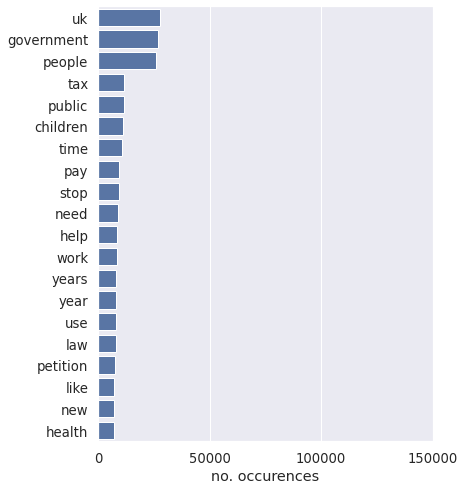

In [11]:
alltokens = [token for row in df['Tokens'] for token in row]
alltokens = pd.Series(alltokens)

f, ax = plt.subplots(figsize=(6, 8))

sns.barplot(x = alltokens.value_counts()[0:20].values, 
            y = alltokens.value_counts()[0:20].index,
            color = sns.color_palette()[0])
ax.set(xlabel="no. occurences", xticks=[0,50000,100000,150000])

plt.show()

## Topic Modelling

Using Gensim's LDA (Latent Dirichlet Allocation) model.

Note this is computationally expensive - use all but one core

In [12]:
ncores = mp.cpu_count()-2

In [13]:
print(len(df), 'samples for topic modelling')
docs = list(df['Tokens'])

57727 samples for topic modelling


#### Create bag of words

In [14]:
dictionary = gensim.corpora.Dictionary(docs)
print('n words:',len(dictionary))

# Filter out words that occur in less than 10 docs, or more than 60% of the docs
dictionary.filter_extremes(no_below=10, no_above=0.6)

print('n words post-filter:',len(dictionary))

# For each doc create a dictionary of words and word freq
corpus = [dictionary.doc2bow(doc) for doc in docs]

n words: 60478
n words post-filter: 13413


In [15]:
# Make a index to word dictionary
temp = dictionary[0]  # to "load" the dictionary
id2word = dictionary.id2token

#### Get tfidf

Term frequency inverse document frequency score will be higher if the term is used more frequently in a document but lower if the term is used in more documents. The idea being that terms with the highest tfidf score for a given document are the most distinguishing ones for that particular document.

In [17]:
tfidf = TfidfModel(corpus, smartirs='ntc')

print([[dictionary[id], freq] for id, freq in corpus[1]])
print()
print([[dictionary[id], freq] for id, freq in tfidf[corpus[1]]])

[['affect', 1], ['british', 1], ['buyers', 1], ['buying', 1], ['central', 1], ['change', 1], ['cities', 1], ['citizens', 2], ['commercial', 1], ['concept', 1], ['differently', 1], ['duty', 1], ['especially', 1], ['essentially', 1], ['everybody', 1], ['extra', 1], ['foreign', 3], ['george', 1], ['ghost', 1], ['guided', 1], ['harsh', 1], ['heavy', 1], ['homes', 2], ['house', 1], ['implemented', 1], ['impose', 1], ['imposing', 1], ['issue', 1], ['land', 1], ['like', 1], ['london', 1], ['lowered', 1], ['mansion', 1], ['market', 2], ['meaningless', 1], ['million', 2], ['mis', 1], ['nationals', 1], ['oil', 1], ['osbornes', 1], ['pave', 1], ['pounds', 1], ['priced', 1], ['prices', 1], ['properties', 2], ['property', 2], ['real', 1], ['reforms', 1], ['second', 1], ['similar', 1], ['sound', 1], ['stamp', 1], ['step', 1], ['tax', 4], ['tenth', 1], ['terrified', 1], ['use', 1], ['way', 1], ['wealthy', 1], ['worth', 1]]

[['affect', 0.09388608602011515], ['british', 0.056425803965996925], ['buyers

#### Save docs, dictionary, corpus and tfidf model to file

In [23]:
write_pkl('models/topicmodel_docs_dict_corpus_tfidf.pkl', (docs, dictionary, corpus, tfidf))

Saved to models/topicmodel_docs_dict_corpus_tfidf.pkl


#### Function to get model topic coherence

There are many coherence measures - see https://radimrehurek.com/gensim/models/ldamodel.html#gensim.models.ldamodel.LdaModel.top_topics.

Below we are evaluating the more commonly used - c_v and u_mass

In [22]:
def get_topic_coherence(model, coherence, num_topics):
    
    top_topics = model.top_topics(corpus, coherence=coherence, texts=docs, dictionary=dictionary) #, num_words=20)
    # Average topic coherence: sum of topic coherences of all topics, divided by no. of topics
    avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics

    return (top_topics, avg_topic_coherence)

### Train LDA model

Things to note:

#### DATA

As outlined above, the data used for topic extraction is UK Parliament e-petitions. The data fields used are *action*, *background* and *additional information* combined (column `Tokens`).

#### MODEL PARAMETERS

* number of topics is optimised around 30 topics (tested from 5 to 80 topics, saved only 22 to 32 topics)
* if all docs will fit in memory (chunksize >= number of training docs) then this gives better coherence scores than passing smaller chunks 
* tuning of eta and alpha parameters has not been explored (nor number of passes and iterations required for convergence)

In [35]:
# coherence score data fields to store
cohdf_cols = ['num_topics','coherence_measure','avg_topic_coherence','top_topics','model']

# load coherence dataframe from pickle, or create if doesn't exist
try :
    coherence_df = read_pkl('models/topic_coherence.pkl')
    print('Loaded topic coherence dataframe')
except :
    coherence_df = pd.DataFrame(columns = cohdf_cols)

## TRAIN MODEL

# Train model(/s) for specified number of topics
for num_topics in [14,16,18,20,22,24,26,28,30,32,34]: #4,6,8,10,12

    # Set training parameters
    chunksize = len(docs) # all docs in one go
    passes = 20
    iterations = 400
    eval_every = None  # Don't evaluate model perplexity, takes too much time

    # train model
    model = gensim.models.LdaMulticore(
        corpus=tfidf[corpus],
        #corpus=corpus,
        id2word=id2word,
        chunksize=chunksize,
    #    alpha='auto', # alpha auto tuning not available in multi-core mode, use LdaModel
        eta='auto',
        iterations=iterations,
        num_topics=num_topics,
        passes=passes,
        eval_every=eval_every,
        workers=ncores
    )

    # save model to file
    modelstr = 'LDAmodel_%03dtopics' % (num_topics)
    write_pkl('models/'+modelstr+'.pkl', model)
    
    # calculate topic coherence measures
    for coherence in ['u_mass','c_v']: #,'c_uci','c_npmi']:
        
        print('\t', coherence, 'calculated')
        (top_topics, avg_topic_coherence) = get_topic_coherence(model=model, coherence=coherence, num_topics=num_topics)
        
        # append to dataframe
        cohdf_data = [[num_topics, coherence, avg_topic_coherence, top_topics, modelstr]]
        coherence_df = coherence_df.append(pd.DataFrame(cohdf_data, columns=cohdf_cols),
                                           ignore_index=True)

# update coherence dataframe pickle file
write_pkl('models/topic_coherence.pkl', coherence_df)

Loaded topic coherence dataframe
Saved to models/LDAmodel_014topics.pkl
	 u_mass calculated
	 c_v calculated
Saved to models/LDAmodel_016topics.pkl
	 u_mass calculated
	 c_v calculated
Saved to models/LDAmodel_018topics.pkl
	 u_mass calculated
	 c_v calculated
Saved to models/LDAmodel_020topics.pkl
	 u_mass calculated
	 c_v calculated
Saved to models/LDAmodel_022topics.pkl
	 u_mass calculated
	 c_v calculated
Saved to models/LDAmodel_024topics.pkl
	 u_mass calculated
	 c_v calculated
Saved to models/LDAmodel_026topics.pkl
	 u_mass calculated
	 c_v calculated
Saved to models/LDAmodel_028topics.pkl
	 u_mass calculated
	 c_v calculated
Saved to models/LDAmodel_030topics.pkl
	 u_mass calculated
	 c_v calculated
Saved to models/LDAmodel_032topics.pkl
	 u_mass calculated
	 c_v calculated
Saved to models/LDAmodel_034topics.pkl
	 u_mass calculated
	 c_v calculated
Saved to models/topic_coherence.pkl


#### Plot topic coherence versus number of topics

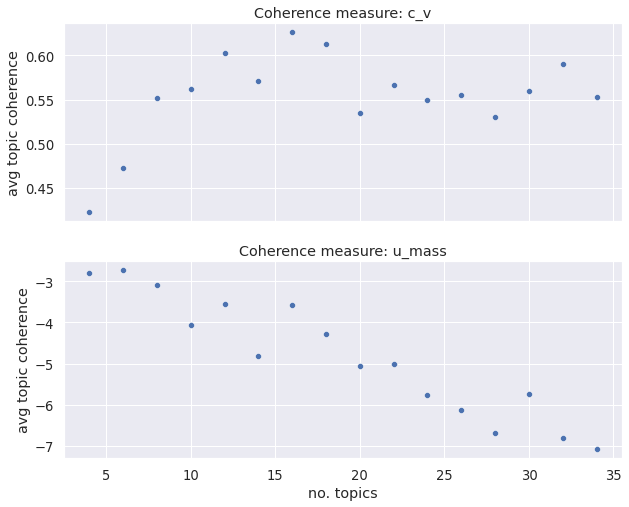

In [36]:
coherence_df = read_pkl('models/topic_coherence.pkl')

fig, ax = plt.subplots(2, 1, figsize=(10,8), sharex=True)

sns.scatterplot(x = "num_topics", y = "avg_topic_coherence",
                data = coherence_df[coherence_df['coherence_measure'] == 'c_v'],
                ax = ax[0])
ax[0].set_ylabel('avg topic coherence')
ax[0].set_xlabel('no. topics')
#ax[0].legend(facecolor='white', loc='upper left', bbox_to_anchor=(1, 1))
ax[0].set_title('Coherence measure: c_v')

sns.scatterplot(x = "num_topics", y = "avg_topic_coherence",
                data = coherence_df[coherence_df['coherence_measure'] == 'u_mass'],
                ax=ax[1])
ax[1].set_ylabel('avg topic coherence')
ax[1].set_xlabel('no. topics')
#ax[1].get_legend().remove()
ax[1].set_title('Coherence measure: u_mass')

plt.show()

The model topic coherences show that
* using both charitable objects *and* aims and activities is better than aims and activities alone, and
* number of topics is optimised at 27 topics

## Visualise model

#### Load model from file

In [37]:
num_topics = 16

modelstr = 'LDAmodel_%03dtopics' % (num_topics)
model = read_pkl('models/%s.pkl' % (modelstr))

#### Print model topic word clouds to file

In [39]:
if not os.path.exists('models/'+modelstr):
    os.mkdir('models/'+modelstr)

for t in range(model.num_topics):
    fig, ax = plt.subplots(dpi=300)
    ax = plt.imshow(WordCloud(background_color='white',
                              width=800,
                              height=400
                             ).fit_words(dict(model.show_topic(t,200))))
    plt.axis("off")
    plt.title("Topic " + str(t+1))
    plt.tight_layout()
    plt.savefig('models/%s/topic%03d.png' % (modelstr,t+1), format='png')
    plt.close(fig)

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus, dictionary=dictionary, mds='mmds', sort_topics=False)
vis